In [1]:
cd /Users/dcox/Dropbox/InsightFellowship/Glimpse/Redacted & Subset Data/

/Users/dcox/Dropbox/InsightFellowship/Glimpse/Redacted & Subset Data


## Standard setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import matplotlib
matplotlib.rc('figure', figsize=(7, 7))

In [3]:
most_feats = pd.read_csv('most_feats_cont.csv')

In [4]:
mostFeats_MathOutc = most_feats['ScantronMathPostTest']
mostFeats_ReadOutc = most_feats['ScantronReadingPostTest']
mostFeats_pred = most_feats.drop(['ScantronMathPostTest', 'ScantronReadingPostTest'], axis=1)

In [5]:
mostFeats_predCols = list(mostFeats_pred)
mostFeats_predCodes = []
for i in mostFeats_predCols:
    mostFeats_pred[i] = mostFeats_pred[i].astype('category')
    d = dict(enumerate(mostFeats_pred[i].cat.categories))
    mostFeats_predCodes.append(d)
    mostFeats_pred[i] = mostFeats_pred[i].astype('category')
    mostFeats_pred[i] = mostFeats_pred[i].cat.codes

In [24]:
# Function we'll use for plotting throughout. 
def line_plot(x):
    '''Returns lineplot of r^2 values for model tested.'''
    plt.plot(r2_vals, marker='o', color='viridis', alpha=0.1)
    plt.xlabel('Hyperparam Values Order')
    plt.ylabel('R^2')
    print("Highest R^2:", max(x))

def lin_metrics(x, y):
    ''' Prints four common metrics for evaluating regression predictions. '''
    print('Mean Absolute Error:', round(metrics.mean_absolute_error(x, y), 4))
    print('Mean Squared Error:', round(metrics.mean_squared_error(x, y), 4))
    print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(x, y)), 4))
    print('R^2 Math:,', round(r2_score(y_test, y_pred), 4))

def scat_plot(x, y, xmin, xmax, ymin, ymax):
    plt.figure(figsize=(7, 7))
    plt.scatter(x, y, color='blue', alpha=0.1)
    plt.xlim(xmin, xmax)
    plt.ylim(xmin, xmax)
    plt.xlabel('Predicted', fontsize=20)
    plt.ylabel('Observed', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

# Create a list of all student-teacher-technology combinations for predictions. 

In [8]:
teachers = mostFeats_pred['TNUM'].unique()
print('Number of Unique Teachers:', len(teachers))

Number of Unique Teachers: 278


In [9]:
grade = mostFeats_pred['GR'].unique()
print('Number of Unique Grades:', len(grade))

Number of Unique Grades: 6


In [11]:
# Only showing grades 3-4 for the demo. 
student3 = mostFeats_pred.loc[mostFeats_pred['GR'] == 3]
student4 = mostFeats_pred.loc[mostFeats_pred['GR'] == 4]
student5 = mostFeats_pred.loc[mostFeats_pred['GR'] == 5]

In [17]:
teach3 = student3['TNUM'].unique()
teach4 = student4['TNUM'].unique()
teach5 = student5['TNUM'].unique()
math_tool = student3['IXLMathUser'].unique()
read_tool = student3['IXLReadingUser'].unique()

In [15]:
# Function to create combinations. 
def create_combos(teacher, math_tool, reading_tool, student, df_to_append):    
    for i in teacher:
        for j in math_tool:
            for k in reading_tool:
                data = student.copy()
                data.GR = 3
                data.TNUM = i
                data.MathTool = j
                data.ReadTool = k
                df_to_append.append(data)

In [18]:
# Generate df for predictions for all third and fourth graders who might stay in in the same grade or advance to the next grade. 
all_pred = []
create_combos(teach3, math_tool, read_tool, student3, all_pred)
create_combos(teach4, math_tool, read_tool, student3, all_pred)
create_combos(teach5, math_tool, read_tool, student3, all_pred)
create_combos(teach4, math_tool, read_tool, student4, all_pred)
create_combos(teach5, math_tool, read_tool, student4, all_pred)
all_pred = pd.concat(all_pred)
print("Length:", len(all_pred))
print("Expected Length:", len(student3)*len(teach3)*4 + len(student3)*len(teach4)*4 + len(student3)*len(teach5)*4 +
     len(student4)*len(teach4)*4 + len(student4)*len(teach5)*4)

Length: 8300436
Expected Length: 8300436


# Continuous Variable Predictions:
## The top models were:
- Continuous outcome variables: k-Nearest Neighbors using the most features dataset. 
- Binary outcome variables: Random Forest using the most features dataset with the engineered feature of pre-to-mid-test change. 

## Math outcomes. 

Highest R^2: 0.7520271558379724


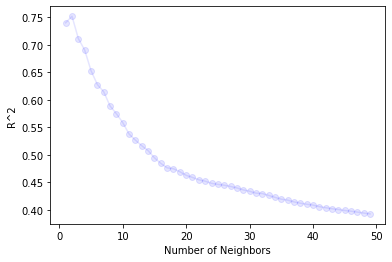

In [20]:
from sklearn.neighbors import KNeighborsRegressor
# Math outcomes. 
X_train, X_test, y_train, y_test = train_test_split(mostFeats_pred, mostFeats_MathOutc, test_size=0.20, random_state = 649)
r2_vals = []
neighbors = list(range(1, 50))
for i in neighbors:
    neigh = KNeighborsRegressor(n_neighbors=i)
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test)
    score = r2_score(y_test, y_pred)
    r2_vals.append(score)
plt.plot(neighbors, r2_vals, marker='o', color='blue', alpha=0.1)
plt.xlabel('Number of Neighbors')
plt.ylabel('R^2')
print("Highest R^2:", max(r2_vals))

#### Optimal neighbors looks like 2. Create model using that number of neighbors. 

0.7520271558379724
Mean Absolute Error: 58.2007
Mean Squared Error: 36119.9325
Root Mean Squared Error: 190.0524
R^2 Math:, 0.752


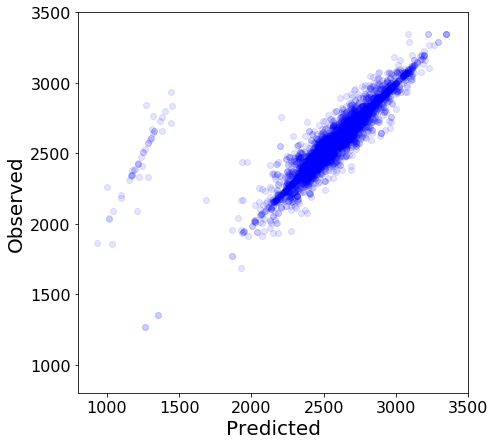

In [25]:
from sklearn.neighbors import KNeighborsRegressor
# Make sure we identified the right number of neighbors. 
X_train, X_test, y_train, y_test = train_test_split(mostFeats_pred, mostFeats_MathOutc, test_size=0.20, random_state=649)
math_neigh = KNeighborsRegressor(n_neighbors=2)
math_neigh_fit = math_neigh.fit(X_train, y_train)
y_pred = math_neigh.predict(X_test)
score = r2_score(y_test, y_pred)
print(score) # should be 0.752271558379724
lin_metrics(y_pred, y_test)
scat_plot(y_pred, y_test, xmin=800, xmax=3500, ymin=800, ymax=3500)

In [28]:
# Train final math model
math_neigh_final = math_neigh.fit(mostFeats_pred, mostFeats_MathOutc)

### Fit the math model to make predictions about all student-teacher combinations. 

In [29]:
# Fit model to prediction data. 
math_final_predict = math_neigh_final.predict(all_pred)

# Reading outcomes. 

Highest R^2: 0.8120433606436155


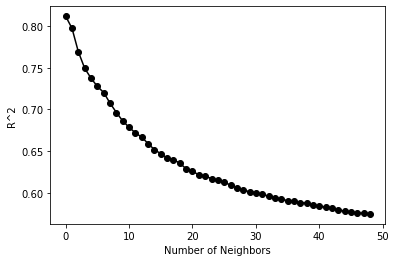

In [30]:
# Reading outcomes. 
X_train, X_test, y_train, y_test = train_test_split(mostFeats_pred, mostFeats_ReadOutc, test_size=0.20, random_state = 649)
r2_vals = []
neighbors = list(range(1, 50))
for i in neighbors:
    neigh = KNeighborsRegressor(n_neighbors=i)
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test)
    score = r2_score(y_test, y_pred)
    r2_vals.append(score)
plt.plot(r2_vals, marker='o', color='black')
plt.xlabel('Number of Neighbors')
plt.ylabel('R^2')
print("Highest R^2:", max(r2_vals))

#### Optimal neighbors looks like 1. Create model using that number of neighbors. 

0.8120433606436155
Mean Absolute Error: 61.8038
Mean Squared Error: 63013.6428
Root Mean Squared Error: 251.0252
R^2 Math:, 0.812


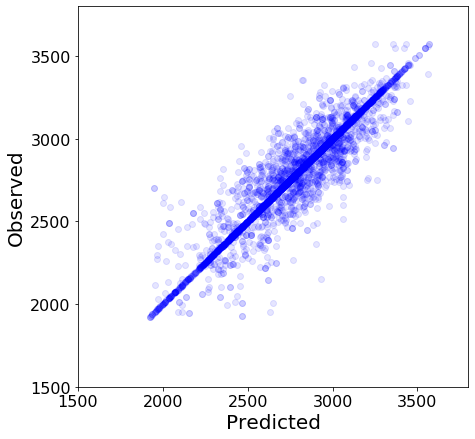

In [26]:
# Make sure we got the right neighbor number. 
X_train, X_test, y_train, y_test = train_test_split(mostFeats_pred, mostFeats_ReadOutc, test_size=0.20, random_state=649)
read_neigh = KNeighborsRegressor(n_neighbors=1)
read_neigh_fit = read_neigh.fit(X_train, y_train)
y_pred = read_neigh.predict(X_test)
score = r2_score(y_test, y_pred)
print(score) # should be 0.0.8120433606436155
lin_metrics(y_test, y_pred)
scat_plot(y_pred, y_test, xmin=1500, xmax=3800, ymin=1500, ymax=3800)

In [31]:
# Train final reading model
read_neigh_final = read_neigh.fit(mostFeats_pred, mostFeats_ReadOutc)

In [32]:
# Fit model to prediction data. 
read_final_predict = read_neigh_final.predict(all_pred)

# Append math and reading predictions to the dataframe. 

In [38]:
all_pred['math_pred_cont'] = math_final_predict
all_pred['read_pred_cont'] = read_final_predict
all_pred = all_pred.drop(['Course','SectionID','Name','School','Type','Year','DistrictID','ScantronMathPreTest',
                           'ScantronReadingPreTest','ScantronMathMidTest','ScantronReadingMidTest',
                           'IXLMathNonUser','IXLMathPartialUser','IXLReadingNon',
                           'IXLReadingPartial'], axis=1)
all_pred.to_csv('all_pred.csv')

In [39]:
all_pred.GlimpsestudentId.unique()

array([ 299,  321,  316, ..., 1266, 1397, 1371])